In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import inspect
import logging
import copy
import importlib
import math
from glob import glob
from pathlib import Path
from datetime import datetime
from textwrap import wrap

In [2]:
# Choose calc_funcs_ver to use in plotting scripts.
cfv = "latest"

assert (isinstance(cfv, str) & (len(cfv) == 5) & (cfv[:3] == "cfv") & 
        cfv[3].isnumeric() & cfv[4].isalpha() & cfv[4].islower()) | (cfv == "latest"), \
    ("cfv must be 'latest' or of form 'cfvXY' where X is a single digit number " +
     "and Y is a lowercase alphabet character. eg. cfv1n")

if cfv == "latest":
    calc_funcs_scripts = glob("calc_funcs_*.py")
    calc_funcs_scripts.sort()
    calc_funcs_module = calc_funcs_scripts[-1][:-3]
    
else:
    calc_funcs_module = "calc_funcs_" + cfv[2:]
    
cf = importlib.import_module(calc_funcs_module)

print(f"Using: {calc_funcs_module}")

Using: calc_funcs_v1n


In [3]:
try:
    plot_funcs_ver = "pf" + Path(__file__).stem[-3:]
except:
    plot_funcs_ver = "pfv00"
plt.rcParams['text.usetex'] = True
da_dims_valid = ("latitude", "longitude")
da_names_cyclic = ["hour_max", "hour_min"]
da_names_viridis_with_vmin_0 = ["lse", "ssgo"] + cf.params_glass_mean
da_names_viridis = ["range"] + cf.params_wsd
vars_viridis_with_vmin_0 = []
vars_viridis = ["ws10", "ws100", "mslp", "t2", 
                "vipile", "vike", "tcclw", "tcwv", 
                "blh", "fa", "cbh", "tcc", "ci"]
figwidth_standard = 10
title_width = 60
perc_quantile_mask_default = 10
eroe100_linthresh = 1e-20

In [4]:
def get_plot_metadata(time_exec_1up, func_1up, args_1up, args_1up_values):
    
    time_str = time_exec_1up.strftime("%Y-%m-%d-%H-%M-%S")
    
    args_1up_list = []
        
    for arg in args_1up:
        arg_value = args_1up_values[arg]
        arg_value_type = str(type(arg_value))
        
        if ((arg_value_type == "<class 'xarray.core.dataset.Dataset'>") | 
            (arg_value_type == "<class 'xarray.core.dataarray.DataArray'>")):
            arg_str = arg
        else:
            arg_str = str(arg_value)
            
        if arg_value_type == "<class 'str'>":
            arg_str = arg_str.replace(arg_value, f"'{arg_value}'")
              
        if arg_value_type == "<class 'function'>":
            arg_str = arg_str.split(" ")[1]
                
        args_1up_list.append(arg_str)
            
    args_1up_str = ", ".join(arg_input for arg_input in args_1up_list)
    
    return {"History": f"{func_1up}({args_1up_str})_{time_str}"}

In [5]:
def apply_mask(da, frame_comp):
    
    da_masked = da
    _, _, _, args_comp_values = inspect.getargvalues(frame_comp)
    
    calc_func_name = args_comp_values["calc_func"].__name__
    region = args_comp_values["region"]
    period1_start = args_comp_values["period1_start"]
    period1_end = args_comp_values["period1_end"]
    period2_start = args_comp_values["period2_start"]
    period2_end = args_comp_values["period2_end"]
    months_subset = args_comp_values["months_subset"]
    arg_extra = args_comp_values["arg_extra"]
    glass_source_pref = args_comp_values["glass_source_pref"]
    var_or_dvar = args_comp_values["var_or_dvar"]
    mask_period1 = args_comp_values["mask_period1"]
    mask_period2 = args_comp_values["mask_period2"]
    cfv_data = args_comp_values["cfv_data"]
            
    path_period1 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period1_start, 
        period_end=period1_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    path_period2 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period2_start, 
        period_end=period2_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    
    # Use data outputted from an older version of the calc_funcs script. This is useful
    # for results which required computationally intensive processing. And can also be
    # set as "cfv00" to analyse test results output from a calc_funcs ipynb notebook.
    
    if cfv_data:
        for path in [path_period1, path_period2]:
            path = path.replace(cf.calc_funcs_ver, cfv_data)
                    
    ds_period1 = xr.open_dataset(path_period1, engine = "netcdf4")
    ds_period2 = xr.open_dataset(path_period2, engine = "netcdf4")
            
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        if var_or_dvar in cf.params_vector:
            pass
        else:
            da_period1 = ds_period1[var_or_dvar].sel(hour=arg_extra)
            da_period2 = ds_period2[var_or_dvar].sel(hour=arg_extra)
    elif (var_or_dvar in cf.params_vector) & (arg_extra in ["max", "min", "mean"]):
        pass
    else:
        da_period1 = ds_period1[arg_extra]
        da_period2 = ds_period2[arg_extra]
    
    if mask_period1 == "pos":
        da_masked = da_masked.where(da_period1 < 0)
    elif mask_period1 == "neg":
        da_masked = da_masked.where(da_period1 >= 0)
        
    if mask_period2 == "pos":
        da_masked = da_masked.where(da_period2 < 0)
    elif mask_period2 == "neg":
        da_masked = da_masked.where(da_period2 >= 0)
    
    return da_masked

In [6]:
def get_common_cbar_limits(
    calc_func, region, period1_start, period1_end, period2_start, period2_end, 
    months_subset, arg_extra, glass_source_pref=None, var_or_dvar=None, 
    extents=None, cfv_data=None
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    frame_1up = frame_cur.f_back
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    calc_func_name = calc_func.__name__
    
    cf.check_args_for_none(calc_func_name, args_cur, args_cur_values)
    cf.check_args(calc_func=calc_func, region=region, period_start=period1_start, 
                  period_end=period1_end, months_subset=months_subset, 
                  glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar)
    cf.check_args(period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset)
    
    if calc_func_name == "calc_glass_mean_clim":
        assert arg_extra in cf.params_glass_mean, \
            (f"arg_extra must be one of: {cf.params_glass_mean} " +
             f"for calc_func = {calc_func_name}")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        assert arg_extra in cf.hours_all, \
            (f"arg_extra must be one of: {cf.hours_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        assert arg_extra in cf.params_stat, \
            (f"arg_extra must be one of: {cf.params_stat} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_wsd_clim":
        assert arg_extra in cf.params_wsd, \
            (f"arg_extra must be one of: {cf.params_wsd} " +
             f"for calc_func = {calc_func_name}")
        
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
        
    path_period1 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period1_start, 
        period_end=period1_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    path_period2 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period2_start, 
        period_end=period2_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    
    # Use data outputted from an older version of the calc_funcs script. This is useful
    # for results which required computationally intensive processing. And can also be
    # set as "cfv00" to analyse test results output from a calc_funcs ipynb notebook.
    
    if cfv_data:
        assert (isinstance(cfv_data, str) & (len(cfv_data) == 5) & 
                (cfv_data[:3] == "cfv") & cfv_data[3].isnumeric() & 
                cfv_data[4].isalpha() & cfv_data[4].islower()) | (cfv_data == "cfv00"), \
            ("cfv_data must be 'cfv00' or of form 'cfvXY' where X is a single digit " +
             "number and Y is a lowercase alphabet character. eg. cfv1n")
        for path in [path_period1, path_period2]:
            path = path.replace(cf.calc_funcs_ver, cfv_data)
            if Path(path).exists() == False:
                msg_cfv = (f"TERMINATED: cfv_data = {cfv_data} was specified " +
                           f"but could not find file: {path}")
                logging.error(msg_cfv)
                print(msg_cfv)
                cf.remove_handlers_if_directly_executed(func_1up)
                raise Exception(msg_cfv)
    
    if Path(path_period1).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_period1}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period1_start, period_end=period1_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    
    ds_period1 = (xr.open_dataset(path_period1, engine = "netcdf4")
                  .sel(longitude=slice(extents[0], extents[1]), 
                       latitude=slice(extents[3], extents[2]))
                 )
    
    if Path(path_period2).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_period2}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    
    ds_period2 = (xr.open_dataset(path_period2, engine = "netcdf4")
                  .sel(longitude=slice(extents[0], extents[1]), 
                       latitude=slice(extents[3], extents[2]))
                 )
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        if var_or_dvar in cf.params_vector:
            da_u_period1 = ds_period1[var_or_dvar.replace("wv", "u")].sel(hour=arg_extra)
            da_v_period1 = ds_period1[var_or_dvar.replace("wv", "v")].sel(hour=arg_extra)
            da_u_period2 = ds_period2[var_or_dvar.replace("wv", "u")].sel(hour=arg_extra)
            da_v_period2 = ds_period2[var_or_dvar.replace("wv", "v")].sel(hour=arg_extra)
            da_mag_period1 = cf.get_magnitude(da_u_period1, da_v_period1)
            da_mag_period2 = cf.get_magnitude(da_u_period2, da_v_period2)
            vmin = 0
            vmax = float(max(da_mag_period1.max(), da_mag_period2.max()))
        else:
            da_period1 = ds_period1[var_or_dvar].sel(hour=arg_extra)
            da_period2 = ds_period2[var_or_dvar].sel(hour=arg_extra)
            if func_1up == "create_individual_comp_plot":
                da_period1 = apply_mask(da_period1, frame_1up)
                da_period2 = apply_mask(da_period2, frame_1up)
            main_param_period2 = (da_period2.attrs["abbreviation"]
                                  .split("(")[-1]
                                  .split(")")[0]
                                  .split("^")[0]
                                  .split("$")[0]
                                  .lower())
            if da_period2.name in da_names_cyclic:
                vmin = None
                vmax = None
            elif da_period2.name in da_names_viridis_with_vmin_0:
                vmin = 0
                vmax = float(max(da_period1.max(), da_period2.max()))
            elif da_period2.name in da_names_viridis:
                vmin = float(min(da_period1.min(), da_period2.min()))
                vmax = float(max(da_period1.max(), da_period2.max()))
            elif main_param_period2 in vars_viridis_with_vmin_0:
                vmin = 0
                vmax = float(max(da_period1.max(), da_period2.max()))
            elif main_param_period2 in vars_viridis:
                vmin = float(min(da_period1.min(), da_period2.min()))
                vmax = float(max(da_period1.max(), da_period2.max()))
            else:
                min_of_mins = float(min(da_period1.min(), da_period2.min()))
                max_of_maxs = float(max(da_period1.max(), da_period2.max()))
                vmin = min(-abs(min_of_mins), -abs(max_of_maxs))
                vmax = -vmin
    elif (var_or_dvar in cf.params_vector) & (arg_extra in ["max", "min", "mean"]):
        da_u_period1 = ds_period1[arg_extra + "_u"]
        da_v_period1 = ds_period1[arg_extra + "_v"]
        da_u_period2 = ds_period2[arg_extra + "_u"]
        da_v_period2 = ds_period2[arg_extra + "_v"]
        da_mag_period1 = cf.get_magnitude(da_u_period1, da_v_period1)
        da_mag_period2 = cf.get_magnitude(da_u_period2, da_v_period2)
        vmin = 0
        vmax = float(max(da_mag_period1.max(), da_mag_period2.max()))
    else:
        da_period1 = ds_period1[arg_extra]
        da_period2 = ds_period2[arg_extra]
        if func_1up == "create_individual_comp_plot":
            da_period1 = apply_mask(da_period1, frame_1up)
            da_period2 = apply_mask(da_period2, frame_1up)
        main_param_period2 = (da_period2.attrs["abbreviation"]
                              .split("(")[-1]
                              .split(")")[0]
                              .split("^")[0]
                              .split("$")[0]
                              .lower())
        if da_period2.name in da_names_cyclic:
            vmin = None
            vmax = None
        elif da_period2.name in da_names_viridis_with_vmin_0:
            vmin = 0
            vmax = float(max(da_period1.max(), da_period2.max()))
        elif da_period2.name in da_names_viridis:
            vmin = float(min(da_period1.min(), da_period2.min()))
            vmax = float(max(da_period1.max(), da_period2.max()))
        elif main_param_period2 in vars_viridis_with_vmin_0:
            vmin = 0
            vmax = float(max(da_period1.max(), da_period2.max()))
        elif main_param_period2 in vars_viridis:
            vmin = float(min(da_period1.min(), da_period2.min()))
            vmax = float(max(da_period1.max(), da_period2.max()))
        else:
            min_of_mins = float(min(da_period1.min(), da_period2.min()))
            max_of_maxs = float(max(da_period1.max(), da_period2.max()))
            vmin = min(-abs(min_of_mins), -abs(max_of_maxs))
            vmax = -vmin
    
    if math.isnan(vmin) & math.isnan(vmax):
        raise Exception("Both vmin and vmax are nans. Make sure that any masks " +
                        "applied don't cover the entire dataset.")
    
    cf.remove_handlers_if_directly_executed(func_1up)
    
    return vmin, vmax

In [7]:
def create_pcolormesh(da, extents=None, vmin=None, vmax=None, ax=None):
    
    frame_2up = inspect.currentframe().f_back.f_back
    func_2up = inspect.getframeinfo(frame_2up)[2]
    
    # Lowest level of plotting; notice that this function will work even for
    # the MDPs of variable dependencies which are not used in the final analysis
    # (eg. vidmf, etc.) as opposed to the higher level plotting functions.
    
    assert ((str(type(da)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da.dims == da_dims_valid)), \
        f"da must be an xarray.DataArray with da.dims == {da_dims_valid}"
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
    else:
        extents = []
        extents.append(da.longitude.min())
        extents.append(da.longitude.max())
        extents.append(da.latitude.min())
        extents.append(da.latitude.max())
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
        
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 1
        figwidth = figwidth_standard
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, ax = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
    
    main_param = (da.attrs["abbreviation"]
                  .split("(")[-1]
                  .split(")")[0]
                  .split("^")[0]
                  .split("$")[0]
                  .lower())
    
    levels = None
    
    if da.attrs["full_name"].split(" ")[1] == "Rolling":
        cmap = cmocean.cm.balance_r
        if (vmin == None) & (vmax == None):
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            min_of_da = float(da_subset.min())
            max_of_da = float(da_subset.max())
            vmin = min(-abs(min_of_da), -abs(max_of_da))
            vmax = -vmin
    elif da.attrs["full_name"].split(" ")[0] == "Difference":
        if da.name in da_names_cyclic:
            cmap = "twilight_shifted_r"
            levels = np.arange(-12, 13)
        else:
            if func_2up == "create_individual_comp_plot":
                da = apply_mask(da, frame_2up)
            cmap = cmocean.cm.balance_r
            if (vmin == None) & (vmax == None):
                da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                                   latitude=slice(extents[3], extents[2]))
                min_of_da = float(da_subset.min())
                max_of_da = float(da_subset.max())
                vmin = min(-abs(min_of_da), -abs(max_of_da))
                vmax = -vmin
    else:
        if da.name in da_names_cyclic:
            cmap = cmocean.cm.phase
            levels = np.arange(0, 25)
        elif da.name in da_names_viridis_with_vmin_0:
            cmap = "viridis"
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            vmin = vmin if vmin else 0
            vmax = vmax if vmax else da_subset.max()
        elif da.name in da_names_viridis:
            cmap = "viridis"
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            vmin = vmin if vmin else da_subset.min()
            vmax = vmax if vmax else da_subset.max()
        elif main_param in vars_viridis_with_vmin_0:
            cmap = "viridis"
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            vmin = vmin if vmin else 0
            vmax = vmax if vmax else da_subset.max()
        elif main_param in vars_viridis:
            cmap = "viridis"
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            vmin = vmin if vmin else da_subset.min()
            vmax = vmax if vmax else da_subset.max()
        else:
            if func_2up == "create_individual_comp_plot":
                da = apply_mask(da, frame_2up)
            cmap = cmocean.cm.balance_r
            if (vmin == None) & (vmax == None):
                da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                                   latitude=slice(extents[3], extents[2]))
                min_of_da = float(da_subset.min())
                max_of_da = float(da_subset.max())
                vmin = min(-abs(min_of_da), -abs(max_of_da))
                vmax = -vmin
    
    ax.set_extent(extents=extents, crs=ccrs.PlateCarree())
    
    if da.attrs["full_name"].split(" ")[1] == "Rolling":
        ax_label = "{}".format(da.attrs["abbreviation"])
    else:
        ax_label = "{} [{}]".format(da.attrs["abbreviation"], da.attrs["units"])
        
    if (da.name == "eroe100") & (da.attrs["units"] == "dimensionless"):
        if da.attrs["full_name"].split(" ")[0] == "Difference":
            da.plot.pcolormesh(ax = ax, cmap = cmap, transform = ccrs.PlateCarree(),
                               norm = colors.SymLogNorm(linthresh=eroe100_linthresh, 
                                                        vmin=vmin, vmax=vmax),
                               cbar_kwargs = {"label": ax_label}
                              )
        else:
            da.plot.pcolormesh(ax = ax, cmap = cmap, transform = ccrs.PlateCarree(),
                               norm = colors.LogNorm(vmin=eroe100_linthresh, vmax=vmax),
                               cbar_kwargs = {"label": ax_label}
                              )
    else:
        da.plot.pcolormesh(ax = ax, cmap = cmap, transform = ccrs.PlateCarree(),
                           vmin = vmin, vmax = vmax, levels = levels, 
                           cbar_kwargs = {"label": ax_label}
                          )
    ax.set_title(da.attrs["full_name"])
    ax.add_feature(cfeature.COASTLINE)
    grid = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    grid.top_labels = False
    grid.right_labels = False
    
    if ax_input == None:
        fig.tight_layout()
        plt.show()
        fig.clear()
        plt.close(fig)

In [8]:
def create_quiver(da_u, da_v, extents=None, vmin=None, vmax=None, ax=None):
    
    assert ((str(type(da_u)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da_u.dims == da_dims_valid)), \
        f"da_u must be an xarray.DataArray with da_u.dims == {da_dims_valid}"
    
    assert ((str(type(da_v)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da_v.dims == da_dims_valid)), \
        f"da_v must be an xarray.DataArray with da_v.dims == {da_dims_valid}"
    
    attrs_u = copy.deepcopy(da_u.attrs)
    attrs_u["abbreviation"] = attrs_u["abbreviation"].replace("_u", "")
    attrs_u["full_name"] = (attrs_u["full_name"]
                            .replace("Zonal Component of ", ""))
    
    attrs_v = copy.deepcopy(da_v.attrs)
    attrs_v["full_name"] = (attrs_v["full_name"]
                            .replace("Meridional Component of ", ""))
    
    assert attrs_u["full_name"] == attrs_v["full_name"], \
        ("da_u and da_v must be the zonal and meridional components " +
         "of the same variable")
    
    vector_test = (attrs_u["abbreviation"]
                   .split("(")[-1]
                   .split(")")[0]
                   .split("^")[0]
                   .split("$")[0]
                   .replace("U", "WV")
                   .lower())
    
    assert vector_test in cf.params_vector, \
        "da_u and da_v must be the components of a vector parameter"
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
    else:
        extents = []
        extents.append(da_u.longitude.min())
        extents.append(da_u.longitude.max())
        extents.append(da_u.latitude.min())
        extents.append(da_u.latitude.max())
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    else:
        vmin = 0
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
        
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 1
        figwidth = figwidth_standard
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, ax = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
        
    da_mag = xr.DataArray(cf.get_magnitude(da_u, da_v), name = "mag")
    da_u_unit = xr.DataArray(da_u / da_mag, name = "u_unit")
    da_v_unit = xr.DataArray(da_v / da_mag, name = "v_unit")
    ds = xr.merge([da_mag, da_u_unit, da_v_unit])
    ax.set_extent(extents=extents, crs=ccrs.PlateCarree())
    ds.plot.quiver(x = "longitude", y = "latitude", ax = ax, 
                   u = "u_unit", v = "v_unit", hue = "mag", 
                   vmin = vmin, vmax = vmax, 
                   cmap = cmocean.cm.speed, transform = ccrs.PlateCarree(),
                   cbar_kwargs={"label": "{} [{}]"
                                .format(attrs_u["abbreviation"], 
                                        attrs_u["units"])
                               }
                  )
    ax.set_title(attrs_u["full_name"])
    ax.add_feature(cfeature.COASTLINE)
    grid = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    grid.top_labels = False
    grid.right_labels = False
    
    if ax_input == None:
        fig.tight_layout()
        plt.show()
        fig.clear()
        plt.close(fig)

In [9]:
def create_individual_calc_plot(
    calc_func, region, period_start, period_end, months_subset, arg_extra, 
    glass_source_pref=None, var_or_dvar=None, extents=None,
    vmin=None, vmax=None, ax=None, cfv_data=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    calc_func_name = calc_func.__name__
    
    cf.check_args_for_none(calc_func_name, args_cur, args_cur_values)
    cf.check_args(calc_func=calc_func, region=region, period_start=period_start, 
                  period_end=period_end, months_subset=months_subset, 
                  glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar)
    
    months_str = cf.get_months_subset_str(months_subset=months_subset).upper()
    
    if calc_func_name == "calc_glass_mean_clim":
        assert arg_extra in cf.params_glass_mean, \
            (f"arg_extra must be one of: {cf.params_glass_mean} " +
             f"for calc_func = {calc_func_name}")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        assert arg_extra in cf.hours_all, \
            (f"arg_extra must be one of: {cf.hours_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        assert arg_extra in cf.params_stat, \
            (f"arg_extra must be one of: {cf.params_stat} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_wsd_clim":
        assert arg_extra in cf.params_wsd, \
            (f"arg_extra must be one of: {cf.params_wsd} " +
             f"for calc_func = {calc_func_name}")
    
    extents_input = copy.deepcopy(extents)
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
    
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 1
        figwidth = figwidth_standard
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, ax = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
        
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    path_calc = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period_start, 
        period_end=period_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    
    # Use data outputted from an older version of the calc_funcs script. This is useful
    # for results which required computationally intensive processing. And can also be
    # set as "cfv00" to analyse test results output from a calc_funcs ipynb notebook.
    
    if cfv_data:
        assert (isinstance(cfv_data, str) & (len(cfv_data) == 5) & 
                (cfv_data[:3] == "cfv") & cfv_data[3].isnumeric() & 
                cfv_data[4].isalpha() & cfv_data[4].islower()) | (cfv_data == "cfv00"), \
            ("cfv_data must be 'cfv00' or of form 'cfvXY' where X is a single digit " +
             "number and Y is a lowercase alphabet character. eg. cfv1n")
        path_calc = path_calc.replace(cf.calc_funcs_ver, cfv_data)
        if Path(path_calc).exists() == False:
            msg_cfv = (f"TERMINATED: cfv_data = {cfv_data} was specified " +
                       f"but could not find file: {path_calc}")
            logging.error(msg_cfv)
            print(msg_cfv)
            cf.remove_handlers_if_directly_executed(func_1up)
            raise Exception(msg_cfv)
    
    if Path(path_calc).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_calc}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period_start, period_end=period_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    
    ds_calc = xr.open_dataset(path_calc, engine = "netcdf4")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        if var_or_dvar in cf.params_vector:
            da_u = ds_calc[var_or_dvar.replace("wv", "u")].sel(hour=arg_extra)
            da_v = ds_calc[var_or_dvar.replace("wv", "v")].sel(hour=arg_extra)
            create_quiver(da_u=da_u, da_v=da_v, extents=extents, 
                          vmin=vmin, vmax=vmax, ax=ax)
        else:
            da_calc = ds_calc[var_or_dvar].sel(hour=arg_extra)
            create_pcolormesh(da=da_calc, extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    elif (var_or_dvar in cf.params_vector) & (arg_extra in ["max", "min", "mean"]):
        da_u = ds_calc[arg_extra + "_u"]
        da_v = ds_calc[arg_extra + "_v"]
        create_quiver(da_u=da_u, da_v=da_v, extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    else:
        da_calc = ds_calc[arg_extra]
        create_pcolormesh(da=da_calc, extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    
    ax_title = ax.get_title()
    
    if calc_func_name == "calc_glass_mean_clim":
        source_str = ds_calc[arg_extra].attrs["source"].upper()
        ax.set_title("\n".join(wrap(f"{ax_title} ({period_start} to {period_end}; " +
                                    f"{months_str} months; {source_str} data)", 
                                    title_width)))
    elif calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        ax.set_title("\n".join(wrap(f"Hour={arg_extra} Value for {ax_title} " +
                                    f"({period_start} to {period_end}; " + 
                                    f"{months_str} months)", title_width)))
    else:
        ax.set_title("\n".join(wrap(f"{ax_title} ({period_start} to {period_end}; " + 
                                    f"{months_str} months)", title_width)))
    
    if ax_input == None:
        fig.tight_layout()
        
        if output == True:
            if cfv_data:
                cfv_used = cfv_data
            else:
                cfv_used = cf.calc_funcs_ver
            
            if extents_input:
                extents_used = "{}W{}E{}S{}N".format(extents[0], extents[1], 
                                                     extents[2], extents[3])
            else:
                extents_used = region
            
            path_output = (path_calc
                           .replace("data_processed", "data_final")
                           .replace(".nc", f"_{arg_extra}.png")
                           .replace(f"{cfv_used}_calc_{region}", 
                                    f"{plot_funcs_ver}_{cfv_used}_calc_{extents_used}")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            path_output = path_output.replace(
                path_output_dir + "/", path_output_dir + "/" + f"{plot_funcs_ver}_")
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()
        fig.clear()
        plt.close(fig)
        
        cf.remove_handlers_if_directly_executed(func_1up)

In [10]:
def create_individual_diff_plot(
    calc_func, region, period1_start, period1_end, period2_start, period2_end, 
    months_subset, arg_extra, glass_source_pref=None, var_or_dvar=None,
    perc=False, perc_quantile_mask=perc_quantile_mask_default, extents=None, 
    vmin=None, vmax=None, ax=None, cfv_data=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    calc_func_name = calc_func.__name__
    
    cf.check_args_for_none(calc_func_name, args_cur, args_cur_values)
    cf.check_args(calc_func=calc_func, region=region, period_start=period1_start, 
                  period_end=period1_end, months_subset=months_subset, 
                  glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar)
    cf.check_args(period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset)
    
    months_str = cf.get_months_subset_str(months_subset=months_subset).upper()
    
    if calc_func_name == "calc_glass_mean_clim":
        assert arg_extra in cf.params_glass_mean, \
            (f"arg_extra must be one of: {cf.params_glass_mean} " +
             f"for calc_func = {calc_func_name}")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        assert arg_extra in cf.hours_all, \
            (f"arg_extra must be one of: {cf.hours_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        assert arg_extra in cf.params_stat, \
            (f"arg_extra must be one of: {cf.params_stat} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_wsd_clim":
        assert arg_extra in cf.params_wsd, \
            (f"arg_extra must be one of: {cf.params_wsd} " +
             f"for calc_func = {calc_func_name}")
    
    assert perc in [True, False], \
        "perc must be one of: [True, False]"
    
    assert perc_quantile_mask in range(0, 101), \
        "perc_quantile_mask must be an integer between 0 and 100 (inclusive)"
    
    extents_input = copy.deepcopy(extents)
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
    
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 1
        figwidth = figwidth_standard
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, ax = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
        
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    path_period1 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period1_start, 
        period_end=period1_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    path_period2 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period2_start, 
        period_end=period2_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    path_diff = cf.get_path_for_calc_diff(
        calc_func_name=calc_func_name, region=region, 
        period1_start=period1_start, period1_end=period1_end, 
        period2_start=period2_start, period2_end=period2_end,
        months_subset=months_subset, glass_source_pref=glass_source_pref,
        var_or_dvar=var_or_dvar
    )
    
    # Use data outputted from an older version of the calc_funcs script. This is useful
    # for results which required computationally intensive processing. And can also be
    # set as "cfv00" to analyse test results output from a calc_funcs ipynb notebook.
    
    if cfv_data:
        assert (isinstance(cfv_data, str) & (len(cfv_data) == 5) & 
                (cfv_data[:3] == "cfv") & cfv_data[3].isnumeric() & 
                cfv_data[4].isalpha() & cfv_data[4].islower()) | (cfv_data == "cfv00"), \
            ("cfv_data must be 'cfv00' or of form 'cfvXY' where X is a single digit " +
             "number and Y is a lowercase alphabet character. eg. cfv1n")
        for path in [path_period1, path_period2, path_diff]:
            path = path.replace(cf.calc_funcs_ver, cfv_data)
            if Path(path).exists() == False:
                msg_cfv = (f"TERMINATED: cfv_data = {cfv_data} was specified " +
                           f"but could not find file: {path}")
                logging.error(msg_cfv)
                print(msg_cfv)
                cf.remove_handlers_if_directly_executed(func_1up)
                raise Exception(msg_cfv)
    
    if Path(path_period1).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_period1}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period1_start, period_end=period1_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    
    ds_period1 = xr.open_dataset(path_period1, engine = "netcdf4")
    
    if Path(path_period2).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_period2}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    
    ds_period2 = xr.open_dataset(path_period2, engine = "netcdf4")
    
    if Path(path_diff).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_diff}"
        logging.info(msg_open)
        print(msg_open)
    else:
        cf.calc_diff(calc_func=calc_func, region=region, 
                     period1_start=period1_start, period1_end=period1_end, 
                     period2_start=period2_start, period2_end=period2_end, 
                     months_subset=months_subset, glass_source_pref=glass_source_pref,
                     var_or_dvar=var_or_dvar)
    
    ds_diff = xr.open_dataset(path_diff, engine = "netcdf4")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        if var_or_dvar in cf.params_vector:
            da_u = ds_diff[var_or_dvar.replace("wv", "u")].sel(hour=arg_extra)
            da_v = ds_diff[var_or_dvar.replace("wv", "v")].sel(hour=arg_extra)
            create_quiver(da_u=da_u, da_v=da_v, extents=extents, 
                          vmin=vmin, vmax=vmax, ax=ax)
        else:
            da_diff = ds_diff[var_or_dvar].sel(hour=arg_extra)
            if perc == True:
                da_period1 = ds_period1[var_or_dvar].sel(hour=arg_extra)
                da_period1_mag = cf.get_magnitude(da_period1, da_period1)
                da_period1_mag = da_period1_mag.where(
                    da_period1_mag > da_period1_mag.quantile(perc_quantile_mask / 100))
                da_diff_perc = da_diff / da_period1_mag * 100
                da_diff_perc.attrs = copy.deepcopy(da_diff.attrs)
                da_diff_perc.attrs["units"] = "\%"
                create_pcolormesh(da=da_diff_perc, extents=extents, 
                                  vmin=vmin, vmax=vmax, ax=ax)
            else:
                create_pcolormesh(da=da_diff, extents=extents, 
                                  vmin=vmin, vmax=vmax, ax=ax)
    elif (var_or_dvar in cf.params_vector) & (arg_extra in ["max", "min", "mean"]):
        da_u = ds_diff[arg_extra + "_u"]
        da_v = ds_diff[arg_extra + "_v"]
        create_quiver(da_u=da_u, da_v=da_v, extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    else:
        da_diff = ds_diff[arg_extra]
        if perc == True:
            da_period1 = ds_period1[arg_extra]
            da_period1_mag = cf.get_magnitude(da_period1, da_period1)
            da_period1_mag = da_period1_mag.where(
                da_period1_mag > da_period1_mag.quantile(perc_quantile_mask / 100))
            da_diff_perc = da_diff / da_period1_mag * 100
            da_diff_perc.attrs = copy.deepcopy(da_diff.attrs)
            da_diff_perc.attrs["units"] = "\% of period 1"
            create_pcolormesh(da=da_diff_perc, extents=extents, 
                              vmin=vmin, vmax=vmax, ax=ax)
        else:
            create_pcolormesh(da=da_diff, extents=extents, 
                              vmin=vmin, vmax=vmax, ax=ax)
    
    ax_title = ax.get_title()
    
    if calc_func_name == "calc_glass_mean_clim":
        source_str = ds_diff[arg_extra].attrs["source"].upper()
        ax.set_title("\n".join(wrap(f"{ax_title} ({period2_start} to {period2_end} " +
                                    f"minus {period1_start} to {period1_end}; " +
                                    f"{months_str} months; {source_str} data)", 
                                    title_width)))
    elif calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        ax_title = ax_title.replace("Difference in ", 
                                    f"Difference in Hour={arg_extra} Value for ")
        ax.set_title("\n".join(wrap(f"{ax_title} ({period2_start} to {period2_end} " +
                                    f"minus {period1_start} to {period1_end}; " + 
                                    f"{months_str} months)", title_width)))
    else:
        ax.set_title("\n".join(wrap(f"{ax_title} ({period2_start} to {period2_end} " +
                                    f"minus {period1_start} to {period1_end}; " + 
                                    f"{months_str} months)", title_width)))
    
    if ax_input == None:
        fig.tight_layout()
        
        if output == True:
            if cfv_data:
                cfv_used = cfv_data
            else:
                cfv_used = cf.calc_funcs_ver
            
            if extents_input:
                extents_used = "{}W{}E{}S{}N".format(extents[0], extents[1], 
                                                     extents[2], extents[3])
            else:
                extents_used = region
                
            path_output = (path_diff
                           .replace("data_processed", "data_final")
                           .replace(".nc", f"_{arg_extra}_perc-{perc_quantile_mask}.png")
                           .replace(f"{cfv_used}_diff_{region}", 
                                    f"{plot_funcs_ver}_{cfv_used}_diff_{extents_used}")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()
        fig.clear()
        plt.close(fig)
        
        cf.remove_handlers_if_directly_executed(func_1up)

In [11]:
def create_individual_comp_plot(
    calc_func, region, period1_start, period1_end, period2_start, period2_end, 
    months_subset, arg_extra, glass_source_pref=None, var_or_dvar=None, perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, mask_period1=None, mask_period2=None, 
    extents=None, vmin_periods=None, vmax_periods=None, vmin_diff=None, vmax_diff=None, 
    ax_period1=None, ax_period2=None, ax_diff=None, cfv_data=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    calc_func_name = calc_func.__name__
    
    cf.check_args_for_none(calc_func_name, args_cur, args_cur_values)
    cf.check_args(calc_func=calc_func, region=region, period_start=period1_start, 
                  period_end=period1_end, months_subset=months_subset, 
                  glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar)
    cf.check_args(period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset)
    
    if calc_func_name == "calc_glass_mean_clim":
        assert arg_extra in cf.params_glass_mean, \
            (f"arg_extra must be one of: {cf.params_glass_mean} " +
             f"for calc_func = {calc_func_name}")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        assert arg_extra in cf.hours_all, \
            (f"arg_extra must be one of: {cf.hours_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        assert arg_extra in cf.params_stat, \
            (f"arg_extra must be one of: {cf.params_stat} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_wsd_clim":
        assert arg_extra in cf.params_wsd, \
            (f"arg_extra must be one of: {cf.params_wsd} " +
             f"for calc_func = {calc_func_name}")
    
    if mask_period1:
        assert (mask_period1 == "pos") | (mask_period1 == "neg"), \
            "mask_period1 must be one of: ['pos', 'neg']"
        
    if mask_period2:
        assert (mask_period2 == "pos") | (mask_period2 == "neg"), \
            "mask_period2 must be one of: ['pos', 'neg']"
    
    assert perc in [True, False], \
        "perc must be one of: [True, False]"
    
    assert perc_quantile_mask in range(0, 101), \
        "perc_quantile_mask must be an integer between 0 and 100 (inclusive)"
    
    extents_input = copy.deepcopy(extents)
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin_periods:
        assert isinstance(vmin_periods, float) | isinstance(vmin_periods, int), \
            "vmin_periods must have data type float or int"
    
    if vmax_periods:
        assert isinstance(vmax_periods, float) | isinstance(vmax_periods, int), \
            "vmax_periods must have data type float or int"
    
    if (vmin_periods is not None) & (vmax_periods is not None):
        assert vmax_periods >= vmin_periods, \
            "vmax_periods must be equal to or greater than vmin_periods"
    
    if (vmin_periods == None) & (vmax_periods == None):
        vmin_periods, vmax_periods = get_common_cbar_limits(
            calc_func=calc_func, region=region, period1_start=period1_start, 
            period1_end=period1_end, period2_start=period2_start, 
            period2_end=period2_end, months_subset=months_subset, 
            arg_extra=arg_extra, glass_source_pref=glass_source_pref,
            var_or_dvar=var_or_dvar, extents=extents, cfv_data=cfv_data
        )
    
    if vmin_diff:
        assert isinstance(vmin_diff, float) | isinstance(vmin_diff, int), \
            "vmin_diff must have data type float or int"
    
    if vmax_diff:
        assert isinstance(vmax_diff, float) | isinstance(vmax_diff, int), \
            "vmax_diff must have data type float or int"
    
    ax_diff_input = ax_diff
    axes_input = [ax_period1, ax_period2, ax_diff]
    
    assert (all(ax_input == None for ax_input in axes_input) | 
            all(ax_input != None for ax_input in axes_input)), \
        "ax_period1, ax_period2, ax_diff must be either all None or all not None"
    
    if ax_diff:
        assert str(type(ax_period1)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax_period1 must be a cartopy.GeoAxesSubplot or None"
        assert str(type(ax_period2)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax_period2 must be a cartopy.GeoAxesSubplot or None"
        assert str(type(ax_diff)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax_diff must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 3
        figwidth = figwidth_standard * 2
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, axes = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                                 subplot_kw = {"projection": ccrs.PlateCarree()}
                                )
        ax_period1 = axes[0]
        ax_period2 = axes[1]
        ax_diff = axes[2]
        
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    path_diff = cf.get_path_for_calc_diff(
        calc_func_name=calc_func_name, region=region, 
        period1_start=period1_start, period1_end=period1_end, 
        period2_start=period2_start, period2_end=period2_end,
        months_subset=months_subset, glass_source_pref=glass_source_pref,
        var_or_dvar=var_or_dvar
    )
    
    # Use data outputted from an older version of the calc_funcs script. This is useful
    # for results which required computationally intensive processing. And can also be
    # set as "cfv00" to analyse test results output from a calc_funcs ipynb notebook.
    
    if cfv_data:
        assert (isinstance(cfv_data, str) & (len(cfv_data) == 5) & 
                (cfv_data[:3] == "cfv") & cfv_data[3].isnumeric() & 
                cfv_data[4].isalpha() & cfv_data[4].islower()) | (cfv_data == "cfv00"), \
            ("cfv_data must be 'cfv00' or of form 'cfvXY' where X is a single digit " +
             "number and Y is a lowercase alphabet character. eg. cfv1n")
        path_diff = path_diff.replace(cf.calc_funcs_ver, cfv_data)
        if Path(path_diff).exists() == False:
            msg_cfv = (f"TERMINATED: cfv_data = {cfv_data} was specified " +
                       f"but could not find file: {path_diff}")
            logging.error(msg_cfv)
            print(msg_cfv)
            cf.remove_handlers_if_directly_executed(func_1up)
            raise Exception(msg_cfv)
    
    create_individual_calc_plot(
        calc_func=calc_func, region=region, period_start=period1_start, 
        period_end=period1_end, months_subset=months_subset, arg_extra=arg_extra, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar, extents=extents, 
        vmin=vmin_periods, vmax=vmax_periods, ax=ax_period1, cfv_data=cfv_data, 
        output=False
    )
    create_individual_calc_plot(
        calc_func=calc_func, region=region, period_start=period2_start, 
        period_end=period2_end, months_subset=months_subset, arg_extra=arg_extra, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar, extents=extents, 
        vmin=vmin_periods, vmax=vmax_periods, ax=ax_period2, cfv_data=cfv_data,
        output=False
    )
    create_individual_diff_plot(
        calc_func=calc_func, region=region, period1_start=period1_start, 
        period1_end=period1_end, period2_start=period2_start, period2_end=period2_end, 
        months_subset=months_subset, arg_extra=arg_extra, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar, 
        perc=perc, perc_quantile_mask=perc_quantile_mask, extents=extents, 
        vmin=vmin_diff, vmax=vmax_diff, ax=ax_diff, cfv_data=cfv_data, output=False
    )
    
    if ax_diff_input == None:
        fig.tight_layout()
        
        if output == True:
            if cfv_data:
                cfv_used = cfv_data
            else:
                cfv_used = cf.calc_funcs_ver
            
            if extents_input:
                extents_used = "{}W{}E{}S{}N".format(extents[0], extents[1], 
                                                     extents[2], extents[3])
            else:
                extents_used = region
            
            path_output = (path_diff
                           .replace("data_processed", "data_final")
                           .replace(".nc", f"_{arg_extra}_perc-{perc_quantile_mask}_" +
                                    f"mask1-{mask_period1}_mask2-{mask_period2}.png")
                           .replace(f"{cfv_used}_diff_{region}", 
                                    f"{plot_funcs_ver}_{cfv_used}_comp_{extents_used}")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()
        fig.clear()
        plt.close(fig)
        
        cf.remove_handlers_if_directly_executed(func_1up)

In [12]:
def create_orog_static_plot(param_orog, region=None, extents=None, vmin=None, vmax=None, 
                            ax=None, cfv_data=None, output=False):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                    args_cur, args_cur_values)
    
    assert param_orog in cf.params_orog, \
        f"param_orog must be one of: {cf.params_orog}"
    
    if region:
        cf.check_args(region=region)
        extents_default = cf.regions[region]["extent"]
    else:
        extents_default = [-180, 180, -90, 90]
        region = "global"
    
    extents_input = copy.deepcopy(extents)
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
        
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 1
        figwidth = figwidth_standard
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, ax = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
    
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    path_orog = cf.get_path_for_era5_orog()
    
    # Use data outputted from an older version of the calc_funcs script. This is useful
    # for results which required computationally intensive processing. And can also be
    # set as "cfv00" to analyse test results output from a calc_funcs ipynb notebook.
    
    if cfv_data:
        assert (isinstance(cfv_data, str) & (len(cfv_data) == 5) & 
                (cfv_data[:3] == "cfv") & cfv_data[3].isnumeric() & 
                cfv_data[4].isalpha() & cfv_data[4].islower()) | (cfv_data == "cfv00"), \
            ("cfv_data must be 'cfv00' or of form 'cfvXY' where X is a single digit " +
             "number and Y is a lowercase alphabet character. eg. cfv1n")
        path_orog = path_orog.replace(cf.calc_funcs_ver, cfv_data)
        if Path(path_orog).exists() == False:
            msg_cfv = (f"TERMINATED: cfv_data = {cfv_data} was specified " +
                       f"but could not find file: {path_orog}")
            logging.error(msg_cfv)
            print(msg_cfv)
            cf.remove_handlers_if_directly_executed(func_1up)
            raise Exception(msg_cfv)
    
    if Path(path_orog).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_orog}"
        logging.info(msg_open)
        print(msg_open)
    else:
        cf.calc_era5_orog()
    
    da_orog = xr.open_dataset(path_orog, engine = "netcdf4")[param_orog]
    
    create_pcolormesh(da_orog, extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    
    if ax_input == None:
        fig.tight_layout()
        
        if output == True:
            if cfv_data:
                cfv_used = cfv_data
            else:
                cfv_used = cf.calc_funcs_ver
            
            if extents_input:
                extents_used = "{}W{}E{}S{}N".format(extents[0], extents[1], 
                                                     extents[2], extents[3])
            else:
                extents_used = region
                
            path_output = (path_orog
                           .replace("data_processed", "data_final")
                           .replace(".nc", f"_{param_orog}.png")
                           .replace(f"{cfv_used}_calc_global", 
                                    f"{plot_funcs_ver}_{cfv_used}_calc_{extents_used}")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()
        fig.clear()
        plt.close(fig)
        
        cf.remove_handlers_if_directly_executed(func_1up)

In [13]:
def create_glass_rolling_plot(region, year_start, year_end, months_subset, window_size, 
                              param_glass_mean, glass_source_pref, extents=None, 
                              vmin=None, vmax=None, cfv_data=None, output=False):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    cf.check_args_for_none(func_cur, args_cur, args_cur_values)
    cf.check_args(region=region, year_start=year_start, year_end=year_end, 
                  months_subset=months_subset, window_size=window_size, 
                  glass_source_pref=glass_source_pref)
    
    assert param_glass_mean in cf.params_glass_mean, \
        f"param_glass_mean must be one of: {cf.params_glass_mean}"
    
    months_str = cf.get_months_subset_str(months_subset=months_subset).upper()
    
    extents_input = copy.deepcopy(extents)
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
    
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
        
    assert output in [True, False], \
        "output must be one of: [True, False]"  
    
    path_roll = cf.get_path_for_calc_glass_rolling(
        region=region, year_start=year_start, year_end=year_end, 
        months_subset=months_subset, window_size=window_size, 
        glass_source_pref=glass_source_pref)
    
    # Use data outputted from an older version of the calc_funcs script. This is useful
    # for results which required computationally intensive processing. And can also be
    # set as "cfv00" to analyse test results output from a calc_funcs ipynb notebook.
    
    if cfv_data:
        assert (isinstance(cfv_data, str) & (len(cfv_data) == 5) & 
                (cfv_data[:3] == "cfv") & cfv_data[3].isnumeric() & 
                cfv_data[4].isalpha() & cfv_data[4].islower()) | (cfv_data == "cfv00"), \
            ("cfv_data must be 'cfv00' or of form 'cfvXY' where X is a single digit " +
             "number and Y is a lowercase alphabet character. eg. cfv1n")
        path_roll = path_roll.replace(cf.calc_funcs_ver, cfv_data)
        if Path(path_roll).exists() == False:
            msg_cfv = (f"TERMINATED: cfv_data = {cfv_data} was specified " +
                       f"but could not find file: {path_roll}")
            logging.error(msg_cfv)
            print(msg_cfv)
            cf.remove_handlers_if_directly_executed(func_1up)
            raise Exception(msg_cfv)
    
    if Path(path_roll).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_roll}"
        logging.info(msg_open)
        print(msg_open)
    else:
        cf.calc_glass_rolling_avg_of_annual_diff(
            region=region, year_start=year_start, year_end=year_end, 
            months_subset=months_subset, window_size=window_size, 
            glass_source_pref=glass_source_pref)
    da_roll = xr.open_dataset(path_roll, engine = "netcdf4")[param_glass_mean]
    
    if cf.priority == "speed":
        da_roll = da_roll.persist()
    
    if (vmin == None) & (vmax == None):
        min_of_da_roll = float(da_roll.min())
        max_of_da_roll = float(da_roll.max())
        vmin = min(-abs(min_of_da_roll), -abs(max_of_da_roll))
        vmax = -vmin    
    
    figcols = 4
    figrows = math.ceil(len(da_roll.year) / figcols)
    figwidth = figwidth_standard * 2
    figheight = (figwidth * figrows/figcols * 
                 (extents[3]-extents[2])/(extents[1]-extents[0])
                )
    fig, axes = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                             subplot_kw = {"projection": ccrs.PlateCarree()}
                            )
    
    for idx, year in enumerate(da_roll.year.data):
        row = math.floor(idx / figcols)
        col = idx % figcols
        da_roll_year = da_roll.sel(year=year)
        create_pcolormesh(da=da_roll_year, extents=extents, 
                          vmin=vmin, vmax=vmax, ax=axes[row, col])
        ax_title = (("{}-Year Rolling Average of Annual Difference in {} " +
                     "(centred upon {}; {} months; {} data)")
                    .format(window_size, param_glass_mean.upper(), year, 
                            months_str, da_roll.attrs[str(year)].upper()))
        axes[row, col].set_title("\n".join(wrap(ax_title, title_width)))
    
    fig.tight_layout()
        
    if output == True:
        if cfv_data:
            cfv_used = cfv_data
        else:
            cfv_used = cf.calc_funcs_ver
            
        if extents_input:
            extents_used = "{}W{}E{}S{}N".format(extents[0], extents[1], 
                                                 extents[2], extents[3])
        else:
            extents_used = region
        
        path_output = (path_roll
                       .replace("data_processed", "data_final")
                       .replace(".nc", f"_{param_glass_mean}.png")
                       .replace(f"{cfv_used}_calc_{region}", 
                                f"{plot_funcs_ver}_{cfv_used}_calc_{extents_used}")
                      )
        path_output_dir = "/".join(path_output.split("/")[:-1])
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            
        if Path(path_output).exists():
            msg_exist = ("WARNING: plot file already exists (and was " +
                         f"not overwritten): {path_output}")
            logging.warning(msg_exist)
            print(msg_exist)
        else:
            plt.savefig(path_output, metadata=get_plot_metadata(
                time_exec, func_cur, args_cur, args_cur_values)
                       )
            msg_create = f"CREATED: plot file: {path_output}"
            logging.info(msg_create)
            print(msg_create)
                
    plt.show()
    fig.clear()
    plt.close(fig)
        
    cf.remove_handlers_if_directly_executed(func_1up)

In [14]:
def plot_mdp_clim_stats_given_var_or_dvar(
    region, period_start, period_end, months_subset, glass_source_pref, var_or_dvar, 
    extents=None, cfv_data=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    cf.check_args_for_none(func_cur, args_cur, args_cur_values)
    cf.check_args(region=region, period_start=period_start, period_end=period_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    
    months_subset_str = cf.get_months_subset_str(months_subset=months_subset)
    
    extents_input = copy.deepcopy(extents)
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    figrows = 5
    figcols = 2
    figwidth = figwidth_standard * 2
    figheight = (figwidth * figrows/figcols * 
                 (extents[3]-extents[2])/(extents[1]-extents[0])
                )
    fig, axes = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                             subplot_kw = {"projection": ccrs.PlateCarree()}
                            )
    
    create_orog_static_plot("lse", extents=extents, ax=axes[0][0], cfv_data=cfv_data)
    create_orog_static_plot("ssgo", extents=extents, ax=axes[0][1], cfv_data=cfv_data)
    create_individual_calc_plot(
        calc_func=cf.calc_glass_mean_clim, region=region, period_start=period_start, 
        period_end=period_end, months_subset=months_subset, arg_extra="mlai", 
        glass_source_pref=glass_source_pref, var_or_dvar=None, extents=extents, 
        ax=axes[1][0], cfv_data=cfv_data
    )
    create_individual_calc_plot(
        calc_func=cf.calc_glass_mean_clim, region=region, period_start=period_start, 
        period_end=period_end, months_subset=months_subset, arg_extra="mfapar", 
        glass_source_pref=glass_source_pref, var_or_dvar=None, extents=extents, 
        ax=axes[1][1], cfv_data=cfv_data
    )
    
    stats_to_plot = cf.params_stat
    
    for stat in ["max_u", "max_v", "min_u", "min_v", "mean_u", "mean_v"]:
        try:
            stats_to_plot.remove(stat)
        except:
            pass
    
    rows_to_skip = 2
    
    for idx, stat in enumerate(stats_to_plot):
        row = math.floor(idx / figcols) + rows_to_skip
        col = idx % figcols
        create_individual_calc_plot(
            calc_func=cf.calc_era5_mdp_clim_stats_given_var_or_dvar, region=region, 
            period_start=period_start, period_end=period_end, 
            months_subset=months_subset, arg_extra=stat, glass_source_pref=None, 
            var_or_dvar=var_or_dvar, extents=extents, ax=axes[row][col], 
            cfv_data=cfv_data
        )
    
    for idx in range(0, figrows * figcols):
        row = math.floor(idx / figcols)
        col = idx % figcols
        ax_title = axes[row][col].get_title()
        axes[row][col].set_title(chr(ord('`')+(idx+1)) + ") " + ax_title)
    
    fig.tight_layout()
    
    if output == True:
        if cfv_data:
            cfv_used = cfv_data
        else:
            cfv_used = cf.calc_funcs_ver
            
        if extents_input:
            extents_used = "{}W{}E{}S{}N".format(extents[0], extents[1], 
                                                 extents[2], extents[3])
        else:
            extents_used = region
            
        path_output = (f"../data_final/mdp_clim_stats_given_var_or_dvar/" +
                       f"{plot_funcs_ver}_{cfv_used}_calc_{extents_used}_" +
                       f"{period_start}_{period_end}_{months_subset_str}_" +
                       f"stats_{var_or_dvar}.png")
        path_output_dir = "/".join(path_output.split("/")[:-1])
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)
        
        if Path(path_output).exists():
            msg_exist = ("WARNING: plot file already exists (and was " +
                         f"not overwritten): {path_output}")
            logging.warning(msg_exist)
            print(msg_exist)
        else:
            plt.savefig(path_output, metadata=get_plot_metadata(
                time_exec, func_cur, args_cur, args_cur_values)
                       )
            msg_create = f"CREATED: plot file: {path_output}"
            logging.info(msg_create)
            print(msg_create)
    
    plt.show()
    fig.clear()
    plt.close(fig)
    
    cf.remove_handlers_if_directly_executed(func_1up)

In [15]:
def plot_mdp_clim_values_given_hour(
    region, period_start, period_end, months_subset, glass_source_pref, hour, 
    var_or_dvar_layer, var_or_dvar_type, extents=None, cfv_data=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    cf.check_args_for_none(func_cur, args_cur, args_cur_values)
    cf.check_args(region=region, period_start=period_start, period_end=period_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  hour=hour, var_or_dvar_layer=var_or_dvar_layer, 
                  var_or_dvar_type=var_or_dvar_type)
    
    months_subset_str = cf.get_months_subset_str(months_subset=months_subset)
    
    extents_input = copy.deepcopy(extents)
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    figrows = 5
    figcols = 2
    figwidth = figwidth_standard * 2
    figheight = (figwidth * figrows/figcols * 
                 (extents[3]-extents[2])/(extents[1]-extents[0])
                )
    fig, axes = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                             subplot_kw = {"projection": ccrs.PlateCarree()}
                            )
    
    create_orog_static_plot("lse", extents=extents, ax=axes[0][0], cfv_data=cfv_data)
    create_orog_static_plot("ssgo", extents=extents, ax=axes[0][1], cfv_data=cfv_data)
    create_individual_calc_plot(
        calc_func=cf.calc_glass_mean_clim, region=region, period_start=period_start, 
        period_end=period_end, months_subset=months_subset, arg_extra="mlai", 
        glass_source_pref=glass_source_pref, var_or_dvar=None, extents=extents, 
        ax=axes[1][0], cfv_data=cfv_data
    )
    create_individual_calc_plot(
        calc_func=cf.calc_glass_mean_clim, region=region, period_start=period_start, 
        period_end=period_end, months_subset=months_subset, arg_extra="mfapar", 
        glass_source_pref=glass_source_pref, var_or_dvar=None, extents=extents, 
        ax=axes[1][1], cfv_data=cfv_data
    )
    
    params_to_plot = cf.vars_and_dvars_era5[var_or_dvar_type][var_or_dvar_layer]
    
    for param in ["ws10", "wv10", "nse", "vidmf", "dws10", "dwv10", "dnse", "dvidmf"]:
        try:
            params_to_plot.remove(param)
        except:
            pass
    
    rows_to_skip = 2
    
    for idx, param in enumerate(params_to_plot):
        row = math.floor(idx / figcols) + rows_to_skip
        col = idx % figcols
        create_individual_calc_plot(
            calc_func=cf.calc_era5_mdp_clim_given_var_or_dvar, region=region, 
            period_start=period_start, period_end=period_end, 
            months_subset=months_subset, arg_extra=hour, glass_source_pref=None, 
            var_or_dvar=param, extents=extents, ax=axes[row][col], cfv_data=cfv_data
        )
    
    for idx in range(0, figrows * figcols):
        row = math.floor(idx / figcols)
        col = idx % figcols
        ax_title = axes[row][col].get_title()
        axes[row][col].set_title(chr(ord('`')+(idx+1)) + ") " + ax_title)
    
    fig.tight_layout()
    
    if output == True:
        if cfv_data:
            cfv_used = cfv_data
        else:
            cfv_used = cf.calc_funcs_ver
            
        if extents_input:
            extents_used = "{}W{}E{}S{}N".format(extents[0], extents[1], 
                                                 extents[2], extents[3])
        else:
            extents_used = region
            
        path_output = (f"../data_final/mdp_clim_values_given_hour/" +
                       f"{plot_funcs_ver}_{cfv_used}_calc_{extents_used}_" +
                       f"{period_start}_{period_end}_{months_subset_str}_" +
                       f"values_{var_or_dvar_layer}_{var_or_dvar_type}_{hour}.png")
        path_output_dir = "/".join(path_output.split("/")[:-1])
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)
        
        if Path(path_output).exists():
            msg_exist = ("WARNING: plot file already exists (and was " +
                         f"not overwritten): {path_output}")
            logging.warning(msg_exist)
            print(msg_exist)
        else:
            plt.savefig(path_output, metadata=get_plot_metadata(
                time_exec, func_cur, args_cur, args_cur_values)
                       )
            msg_create = f"CREATED: plot file: {path_output}"
            logging.info(msg_create)
            print(msg_create)
    
    plt.show()
    fig.clear()
    plt.close(fig)
    
    cf.remove_handlers_if_directly_executed(func_1up)

In [16]:
def plot_mdp_clim_values_given_var_or_dvar(
    region, period_start, period_end, months_subset, glass_source_pref, var_or_dvar, 
    time, extents=None, cfv_data=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    cf.check_args_for_none(func_cur, args_cur, args_cur_values)
    cf.check_args(region=region, period_start=period_start, period_end=period_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar, time=time)
    
    months_subset_str = cf.get_months_subset_str(months_subset=months_subset)
    
    extents_input = copy.deepcopy(extents)
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    figrows = 5
    figcols = 2
    figwidth = figwidth_standard * 2
    figheight = (figwidth * figrows/figcols * 
                 (extents[3]-extents[2])/(extents[1]-extents[0])
                )
    fig, axes = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                             subplot_kw = {"projection": ccrs.PlateCarree()}
                            )
    
    create_orog_static_plot("lse", extents=extents, ax=axes[0][0], cfv_data=cfv_data)
    create_orog_static_plot("ssgo", extents=extents, ax=axes[0][1], cfv_data=cfv_data)
    create_individual_calc_plot(
        calc_func=cf.calc_glass_mean_clim, region=region, period_start=period_start, 
        period_end=period_end, months_subset=months_subset, arg_extra="mlai", 
        glass_source_pref=glass_source_pref, var_or_dvar=None, extents=extents, 
        ax=axes[1][0], cfv_data=cfv_data
    )
    create_individual_calc_plot(
        calc_func=cf.calc_glass_mean_clim, region=region, period_start=period_start, 
        period_end=period_end, months_subset=months_subset, arg_extra="mfapar", 
        glass_source_pref=glass_source_pref, var_or_dvar=None, extents=extents, 
        ax=axes[1][1], cfv_data=cfv_data
    )
    
    hours_to_plot = cf.times[time]
    
    path_calc = cf.get_path_for_calc_func(
        calc_func_name="calc_era5_mdp_clim_given_var_or_dvar", region=region, 
        period_start=period_start, period_end=period_end, months_subset=months_subset, 
        glass_source_pref=None, var_or_dvar=var_or_dvar
    )
    
    # Use data outputted from an older version of the calc_funcs script. This is useful
    # for results which required computationally intensive processing. And can also be
    # set as "cfv00" to analyse test results output from a calc_funcs ipynb notebook.
    
    if cfv_data:
        assert (isinstance(cfv_data, str) & (len(cfv_data) == 5) & 
                (cfv_data[:3] == "cfv") & cfv_data[3].isnumeric() & 
                cfv_data[4].isalpha() & cfv_data[4].islower()) | (cfv_data == "cfv00"), \
            ("cfv_data must be 'cfv00' or of form 'cfvXY' where X is a single digit " +
             "number and Y is a lowercase alphabet character. eg. cfv1n")
        path_calc = path_calc.replace(cf.calc_funcs_ver, cfv_data)
        if Path(path_calc).exists() == False:
            msg_cfv = (f"TERMINATED: cfv_data = {cfv_data} was specified " +
                       f"but could not find file: {path_calc}")
            logging.error(msg_cfv)
            print(msg_cfv)
            cf.remove_handlers_if_directly_executed(func_1up)
            raise Exception(msg_cfv)
    
    if Path(path_calc).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_calc}"
        logging.info(msg_open)
        print(msg_open)
    else:
        cf.calc_era5_mdp_clim_given_var_or_dvar(
            region=region, period_start=period_start, period_end=period_end, 
            months_subset=months_subset, glass_source_pref=None,
            var_or_dvar=var_or_dvar
        )
    
    ds_time = (xr.open_dataset(path_calc, engine = "netcdf4")
               .sel(longitude=slice(extents[0], extents[1]), 
                    latitude=slice(extents[3], extents[2]))
               .sel(hour=slice(hours_to_plot[0], hours_to_plot[-1]))
              )
    
    if var_or_dvar in cf.params_vector:
        ds_time_u = ds_time[var_or_dvar.replace("wv", "u")]
        ds_time_v = ds_time[var_or_dvar.replace("wv", "v")]
        ds_time_mag = cf.get_magnitude(ds_time_u, ds_time_v)
        vmin = 0
        vmax = float(ds_time_mag.max())
    else:
        ds_time = ds_time[var_or_dvar]
        if var_or_dvar in vars_viridis_with_vmin_0:
            vmin = 0
            vmax = float(ds_time.max())
        elif var_or_dvar in vars_viridis:
            vmin = float(ds_time.min())
            vmax = float(ds_time.max())
        else:
            min_ds = float(ds_time.min())
            max_ds = float(ds_time.max())
            vmin = min(-abs(min_ds), -abs(max_ds))
            vmax = -vmin
    
    rows_to_skip = 2
    
    for idx, hour in enumerate(hours_to_plot):
        row = math.floor(idx / figcols) + rows_to_skip
        col = idx % figcols
        create_individual_calc_plot(
            calc_func=cf.calc_era5_mdp_clim_given_var_or_dvar, region=region, 
            period_start=period_start, period_end=period_end, 
            months_subset=months_subset, arg_extra=hour, glass_source_pref=None, 
            var_or_dvar=var_or_dvar, extents=extents, vmin=vmin, vmax=vmax, 
            ax=axes[row][col], cfv_data=cfv_data
        )
    
    for idx in range(0, figrows * figcols):
        row = math.floor(idx / figcols)
        col = idx % figcols
        ax_title = axes[row][col].get_title()
        axes[row][col].set_title(chr(ord('`')+(idx+1)) + ") " + ax_title)
    
    fig.tight_layout()
    
    if output == True:
        if cfv_data:
            cfv_used = cfv_data
        else:
            cfv_used = cf.calc_funcs_ver
            
        if extents_input:
            extents_used = "{}W{}E{}S{}N".format(extents[0], extents[1], 
                                                 extents[2], extents[3])
        else:
            extents_used = region
            
        path_output = (f"../data_final/mdp_clim_values_given_var_or_dvar/" +
                       f"{plot_funcs_ver}_{cfv_used}_calc_{extents_used}_" +
                       f"{period_start}_{period_end}_{months_subset_str}_" +
                       f"values_{var_or_dvar}_{time}.png")
        path_output_dir = "/".join(path_output.split("/")[:-1])
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)
        
        if Path(path_output).exists():
            msg_exist = ("WARNING: plot file already exists (and was " +
                         f"not overwritten): {path_output}")
            logging.warning(msg_exist)
            print(msg_exist)
        else:
            plt.savefig(path_output, metadata=get_plot_metadata(
                time_exec, func_cur, args_cur, args_cur_values)
                       )
            msg_create = f"CREATED: plot file: {path_output}"
            logging.info(msg_create)
            print(msg_create)
    
    plt.show()
    fig.clear()
    plt.close(fig)
    
    cf.remove_handlers_if_directly_executed(func_1up)

In [17]:
def plot_wsd_clim(
    region, period_start, period_end, months_subset, glass_source_pref,  
    extents=None, cfv_data=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    cf.check_args_for_none(func_cur, args_cur, args_cur_values)
    cf.check_args(region=region, period_start=period_start, period_end=period_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref)
    
    months_subset_str = cf.get_months_subset_str(months_subset=months_subset)
    
    extents_input = copy.deepcopy(extents)
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    figrows = 5
    figcols = 2
    figwidth = figwidth_standard * 2
    figheight = (figwidth * figrows/figcols * 
                 (extents[3]-extents[2])/(extents[1]-extents[0])
                )
    fig, axes = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                             subplot_kw = {"projection": ccrs.PlateCarree()}
                            )
    
    create_orog_static_plot("lse", extents=extents, ax=axes[0][0], cfv_data=cfv_data)
    create_orog_static_plot("ssgo", extents=extents, ax=axes[0][1], cfv_data=cfv_data)
    create_individual_calc_plot(
        calc_func=cf.calc_glass_mean_clim, region=region, period_start=period_start, 
        period_end=period_end, months_subset=months_subset, arg_extra="mlai", 
        glass_source_pref=glass_source_pref, var_or_dvar=None, extents=extents, 
        ax=axes[1][0], cfv_data=cfv_data
    )
    create_individual_calc_plot(
        calc_func=cf.calc_glass_mean_clim, region=region, period_start=period_start, 
        period_end=period_end, months_subset=months_subset, arg_extra="mfapar", 
        glass_source_pref=glass_source_pref, var_or_dvar=None, extents=extents, 
        ax=axes[1][1], cfv_data=cfv_data
    )
    
    params_to_plot = cf.params_wsd
    
    for param in ["ws10_mean", "ws10_std", "c10", "k10"]:
        try:
            params_to_plot.remove(param)
        except:
            pass
    
    rows_to_skip = 2
    
    for idx, param in enumerate(params_to_plot):
        row = math.floor(idx / figcols) + rows_to_skip
        col = idx % figcols
        create_individual_calc_plot(
            calc_func=cf.calc_era5_wsd_clim, region=region, period_start=period_start, 
            period_end=period_end, months_subset=months_subset, arg_extra=param, 
            glass_source_pref=None, var_or_dvar=None, extents=extents, 
            ax=axes[row][col], cfv_data=cfv_data
        )
    
    for idx in range(0, figrows * figcols):
        row = math.floor(idx / figcols)
        col = idx % figcols
        ax_title = axes[row][col].get_title()
        axes[row][col].set_title(chr(ord('`')+(idx+1)) + ") " + ax_title)
    
    fig.tight_layout()
    
    if output == True:
        if cfv_data:
            cfv_used = cfv_data
        else:
            cfv_used = cf.calc_funcs_ver
            
        if extents_input:
            extents_used = "{}W{}E{}S{}N".format(extents[0], extents[1], 
                                                 extents[2], extents[3])
        else:
            extents_used = region
            
        path_output = (f"../data_final/wsd_clim/{plot_funcs_ver}_{cfv_used}_" +
                       f"calc_{extents_used}_{period_start}_{period_end}_" +
                       f"{months_subset_str}_wsd.png")
        path_output_dir = "/".join(path_output.split("/")[:-1])
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)
        
        if Path(path_output).exists():
            msg_exist = ("WARNING: plot file already exists (and was " +
                         f"not overwritten): {path_output}")
            logging.warning(msg_exist)
            print(msg_exist)
        else:
            plt.savefig(path_output, metadata=get_plot_metadata(
                time_exec, func_cur, args_cur, args_cur_values)
                       )
            msg_create = f"CREATED: plot file: {path_output}"
            logging.info(msg_create)
            print(msg_create)
    
    plt.show()
    fig.clear()
    plt.close(fig)
    
    cf.remove_handlers_if_directly_executed(func_1up)

In [18]:
def plot_diff_mdp_clim_stats_given_var_or_dvar(
    region, period1_start, period1_end, period2_start, period2_end, months_subset, 
    glass_source_pref, var_or_dvar, perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, 
    extents=None, cfv_data=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    cf.check_args_for_none(func_cur, args_cur, args_cur_values)
    cf.check_args(region=region, period_start=period1_start, period_end=period1_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    cf.check_args(period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset)
    
    months_subset_str = cf.get_months_subset_str(months_subset=months_subset)
    
    assert perc in [True, False], \
        "perc must be one of: [True, False]"
    
    assert perc_quantile_mask in range(0, 101), \
        "perc_quantile_mask must be an integer between 0 and 100 (inclusive)"
    
    extents_input = copy.deepcopy(extents)
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    figrows = 5
    figcols = 2
    figwidth = figwidth_standard * 2
    figheight = (figwidth * figrows/figcols * 
                 (extents[3]-extents[2])/(extents[1]-extents[0])
                )
    fig, axes = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                             subplot_kw = {"projection": ccrs.PlateCarree()}
                            )
    
    create_orog_static_plot("lse", extents=extents, ax=axes[0][0], cfv_data=cfv_data)
    create_orog_static_plot("ssgo", extents=extents, ax=axes[0][1], cfv_data=cfv_data)
    create_individual_diff_plot(
        calc_func=cf.calc_glass_mean_clim, region=region, period1_start=period1_start, 
        period1_end=period1_end, period2_start=period2_start, period2_end=period2_end, 
        months_subset=months_subset, arg_extra="mlai", 
        glass_source_pref=glass_source_pref, var_or_dvar=None, perc=perc, 
        perc_quantile_mask=perc_quantile_mask, extents=extents, 
        ax=axes[1][0], cfv_data=cfv_data
    )
    create_individual_diff_plot(
        calc_func=cf.calc_glass_mean_clim, region=region, period1_start=period1_start, 
        period1_end=period1_end, period2_start=period2_start, period2_end=period2_end, 
        months_subset=months_subset, arg_extra="mfapar", 
        glass_source_pref=glass_source_pref, var_or_dvar=None, perc=perc, 
        perc_quantile_mask=perc_quantile_mask, extents=extents, 
        ax=axes[1][1], cfv_data=cfv_data
    )
    
    stats_to_plot = cf.params_stat
    
    for stat in ["max_u", "max_v", "min_u", "min_v", "mean_u", "mean_v"]:
        try:
            stats_to_plot.remove(stat)
        except:
            pass
    
    rows_to_skip = 2
    
    for idx, stat in enumerate(stats_to_plot):
        row = math.floor(idx / figcols) + rows_to_skip
        col = idx % figcols
        create_individual_diff_plot(
            calc_func=cf.calc_era5_mdp_clim_stats_given_var_or_dvar, region=region, 
            period1_start=period1_start, period1_end=period1_end, 
            period2_start=period2_start, period2_end=period2_end, 
            months_subset=months_subset, arg_extra=stat, glass_source_pref=None, 
            var_or_dvar=var_or_dvar, perc=perc, perc_quantile_mask=perc_quantile_mask,
            extents=extents, ax=axes[row][col], cfv_data=cfv_data
        )
    
    for idx in range(0, figrows * figcols):
        row = math.floor(idx / figcols)
        col = idx % figcols
        ax_title = axes[row][col].get_title()
        axes[row][col].set_title(chr(ord('`')+(idx+1)) + ") " + ax_title)
    
    fig.tight_layout()
    
    if output == True:
        if cfv_data:
            cfv_used = cfv_data
        else:
            cfv_used = cf.calc_funcs_ver
            
        if extents_input:
            extents_used = "{}W{}E{}S{}N".format(extents[0], extents[1], 
                                                 extents[2], extents[3])
        else:
            extents_used = region
            
        path_output = (f"../data_final/mdp_clim_stats_given_var_or_dvar/" +
                       f"{plot_funcs_ver}_{cfv_used}_diff_{extents_used}_" +
                       f"{period1_start}_{period1_end}_{period2_start}_" +
                       f"{period2_end}_{months_subset_str}_stats_{var_or_dvar}.png")
        path_output_dir = "/".join(path_output.split("/")[:-1])
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)
        
        if Path(path_output).exists():
            msg_exist = ("WARNING: plot file already exists (and was " +
                         f"not overwritten): {path_output}")
            logging.warning(msg_exist)
            print(msg_exist)
        else:
            plt.savefig(path_output, metadata=get_plot_metadata(
                time_exec, func_cur, args_cur, args_cur_values)
                       )
            msg_create = f"CREATED: plot file: {path_output}"
            logging.info(msg_create)
            print(msg_create)
    
    plt.show()
    fig.clear()
    plt.close(fig)
    
    cf.remove_handlers_if_directly_executed(func_1up)

CREATED: log file for plot_diff_mdp_clim_stats_given_var_or_dvar: ../logs/plot_diff_mdp_clim_stats_given_var_or_dvar/('sa', 'Jan-2003', 'Dec-2007', 'Jan-2016', 'Dec-2020', 'all', 'modis', 'ws100', False, 10, None, None, True)_cfv1n_2022-10-09-12-35-32.
Opening: existing file for use in create_orog_static_plot: ../data_processed/era5_orog/cfv1n_calc_global_era5-orog.nc
Opening: existing file for use in create_orog_static_plot: ../data_processed/era5_orog/cfv1n_calc_global_era5-orog.nc
Opening: existing file for use in create_individual_diff_plot: ../data_processed/glass_mean_clim/cfv1n_calc_sa_Jan-2003_Dec-2007_all_glass-mean_modis.nc
Opening: existing file for use in create_individual_diff_plot: ../data_processed/glass_mean_clim/cfv1n_calc_sa_Jan-2016_Dec-2020_all_glass-mean_modis.nc
Opening: existing file for use in create_individual_diff_plot: ../data_processed/glass_mean_clim/cfv1n_diff_sa_Jan-2003_Dec-2007_Jan-2016_Dec-2020_all_glass-mean_modis.nc
Opening: existing file for use in 

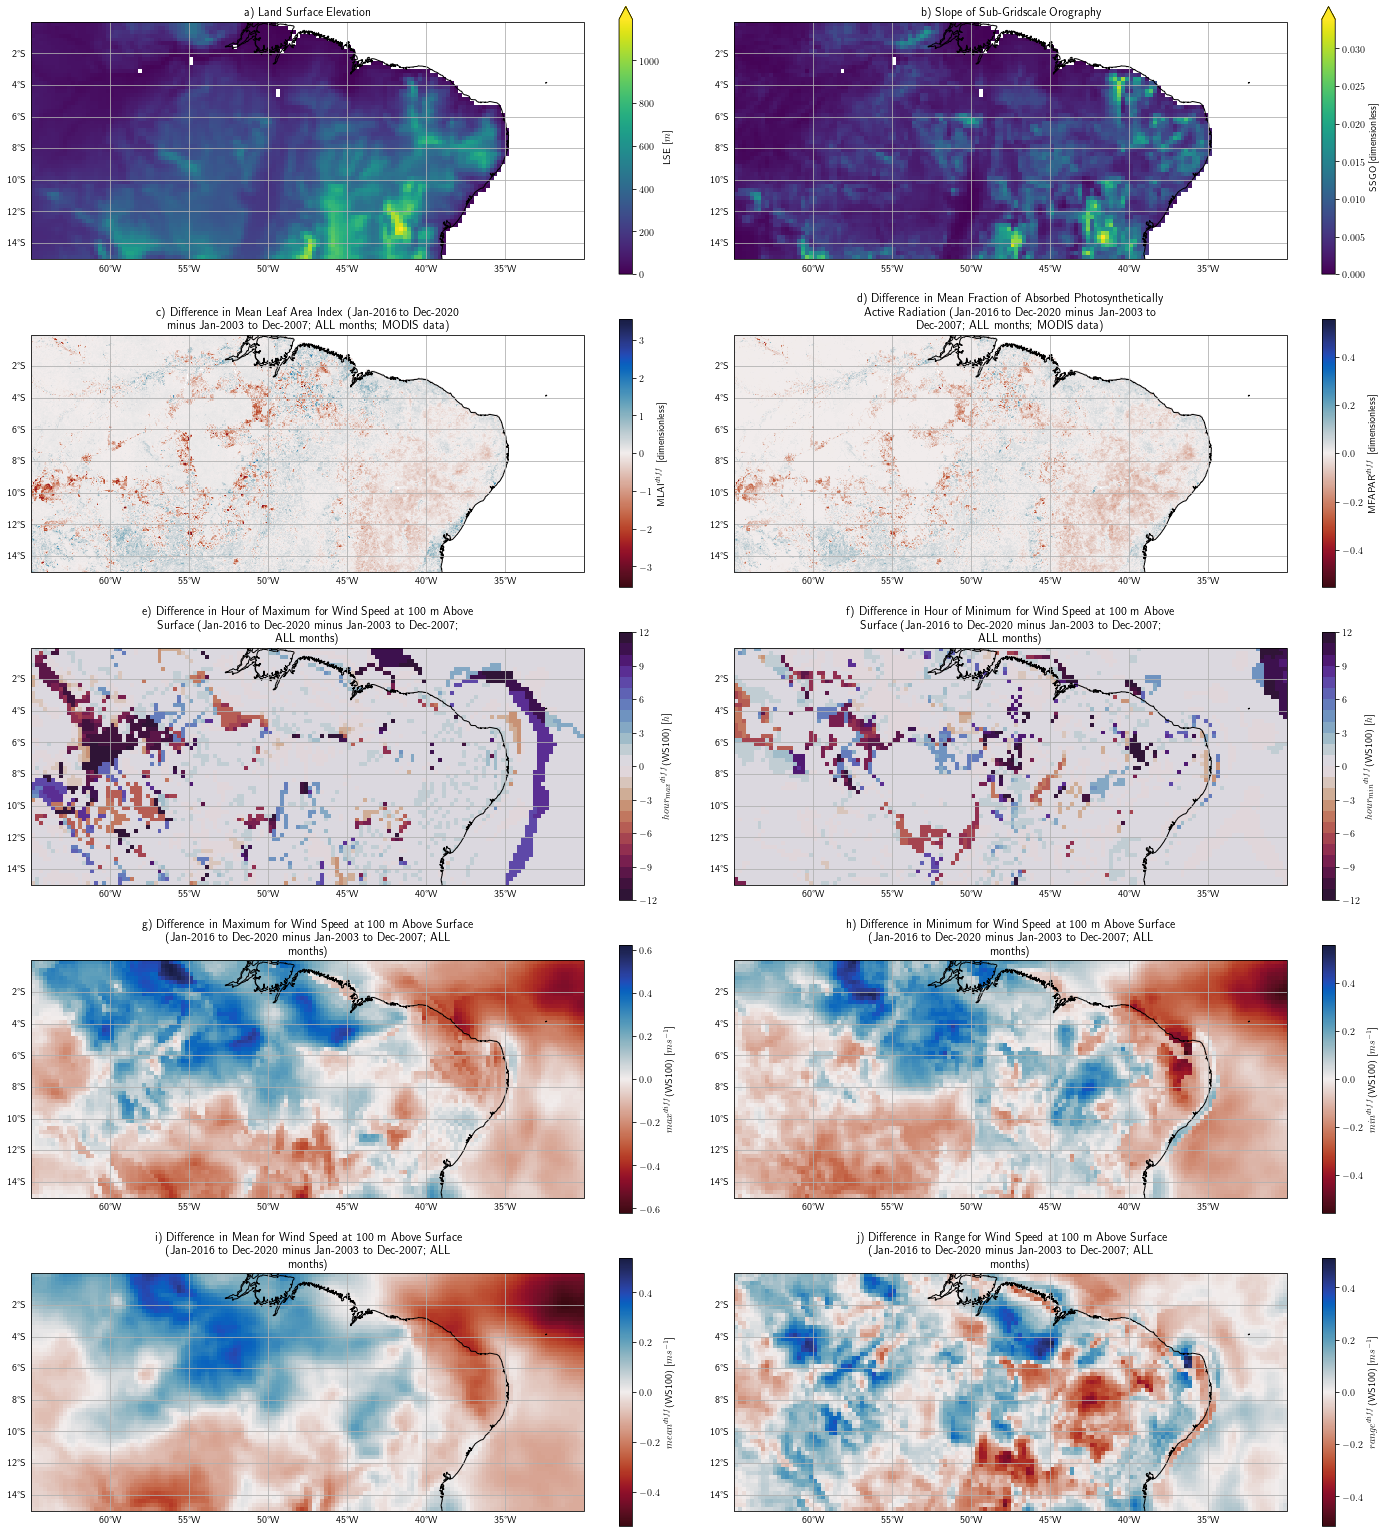

CPU times: user 7.72 s, sys: 2.12 s, total: 9.85 s
Wall time: 7.3 s


In [19]:
%%time
plot_diff_mdp_clim_stats_given_var_or_dvar(
    "sa", "Jan-2003", "Dec-2007", "Jan-2016", "Dec-2020", "all", 
    "modis", "ws100", perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, 
    extents=None, cfv_data=None, output=True
)

In [ ]:
%%time
plot_diff_mdp_clim_stats_given_var_or_dvar(
    "sa", "Jan-2003", "Dec-2007", "Jan-2016", "Dec-2020", "all", 
    "modis", "mslp", perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, 
    extents=None, cfv_data=None, output=True
)

In [ ]:
%%time
plot_diff_mdp_clim_stats_given_var_or_dvar(
    "sa", "Jan-2003", "Dec-2007", "Jan-2016", "Dec-2020", "all", 
    "modis", "nac", perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, 
    extents=None, cfv_data=None, output=True
)

In [ ]:
%%time
plot_diff_mdp_clim_stats_given_var_or_dvar(
    "ca", "Jan-1981", "Dec-1985", "Jan-1992", "Dec-1996", "all", 
    "avhrr", "ws100", perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, 
    extents=None, cfv_data=None, output=True
)

In [ ]:
%%time
plot_diff_mdp_clim_stats_given_var_or_dvar(
    "ca", "Jan-1981", "Dec-1985", "Jan-1992", "Dec-1996", "all", 
    "avhrr", "mslp", perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, 
    extents=None, cfv_data=None, output=True
)

In [ ]:
%%time
plot_diff_mdp_clim_stats_given_var_or_dvar(
    "ca", "Jan-1981", "Dec-1985", "Jan-1992", "Dec-1996", "all", 
    "avhrr", "nac", perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, 
    extents=None, cfv_data=None, output=True
)

In [ ]:
%%time
plot_diff_mdp_clim_stats_given_var_or_dvar(
    "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", 
    "avhrr", "ws100", perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, 
    extents=None, cfv_data=None, output=True
)

In [ ]:
%%time
plot_diff_mdp_clim_stats_given_var_or_dvar(
    "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", 
    "avhrr", "wv100", perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, 
    extents=None, cfv_data=None, output=True
)

In [ ]:
%%time
plot_diff_mdp_clim_stats_given_var_or_dvar(
    "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", 
    "avhrr", "mslp", perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, 
    extents=None, cfv_data=None, output=True
)

In [ ]:
%%time
plot_diff_mdp_clim_stats_given_var_or_dvar(
    "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", 
    "avhrr", "nac", perc=False, 
    perc_quantile_mask=perc_quantile_mask_default, 
    extents=None, cfv_data=None, output=True
)

In [ ]:
# Figure how to display quiver plots properly when there are wide extents

In [ ]:
%%time
create_individual_calc_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "sa", "Jan-2003", "Dec-2007", "all", "mean", var_or_dvar="wv100", output=True)

In [ ]:
%%time
create_individual_calc_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "ca", "Jan-1981", "Dec-1985", "all", "mean", var_or_dvar="wv100", output=True)

In [ ]:
%%time
create_individual_calc_plot(cf.calc_era5_wsd_clim, "wa", "Jan-1994", "Dec-1998", "all", "eroe100", output=True)

In [ ]:
%%time
create_individual_diff_plot(cf.calc_era5_wsd_clim, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "eroe100", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_wsd_clim, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "eroe100", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_wsd_clim, "ca", "Jan-1981", "Dec-1985", "Jan-1992", "Dec-1996", "all", "eroe100", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_wsd_clim, "sa", "Jan-2003", "Dec-2007", "Jan-2016", "Dec-2020", "all", "eroe100", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_wsd_clim, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "eroe100", perc=True, output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_wsd_clim, "ca", "Jan-1981", "Dec-1985", "Jan-1992", "Dec-1996", "all", "eroe100", perc=True, output=True)

In [ ]:
%%time
plot_wsd_clim(
    "wa", "Jan-1994", "Dec-1998", "all", "avhrr",  
    extents=None, cfv_data=None, output=True
)

In [ ]:
%%time
plot_mdp_clim_values_given_var_or_dvar(
    "wa", "Jan-1994", "Dec-1998", "all", "avhrr", "nac", 
    "evening", extents=None, cfv_data=None, output=True
)

In [ ]:
%%time
plot_mdp_clim_values_given_hour(
    "wa", "Jan-1994", "Dec-1998", "all", "avhrr", 12, 
    "sfc", "vars", extents=None, cfv_data=None, output=True)

In [ ]:
%%time
plot_mdp_clim_values_given_hour(
    "wa", "Jan-1994", "Dec-1998", "all", "avhrr", 12, 
    "cld", "vars", extents=None, cfv_data=None, output=True)

In [ ]:
%%time
plot_mdp_clim_stats_given_var_or_dvar("wa", "Jan-1994", "Dec-1998", "all", "avhrr", "tcclw", output=True)

In [ ]:
%%time
plot_mdp_clim_stats_given_var_or_dvar("wa", "Jan-1994", "Dec-1998", "all", "avhrr", "dwv10", output=True)

In [ ]:
%%time
plot_mdp_clim_stats_given_var_or_dvar("wa", "Jan-1994", "Dec-1998", "all", "avhrr", "ci", output=True)

In [ ]:
%%time
plot_mdp_clim_stats_given_var_or_dvar("wa", "Jan-1994", "Dec-1998", "all", "avhrr", "cape", output=True)

In [ ]:
%%time
create_glass_rolling_plot("wa", 1982, 2020, "all", 3, "mlai", glass_source_pref="modis", extents=[118, 122, -35, -31], output=True)

In [ ]:
%%time
create_glass_rolling_plot("wa", 1983, 2019, "all", 5, "mfapar", glass_source_pref="avhrr", output=True)

In [ ]:
%%time
create_glass_rolling_plot("sa", 1984, 2018, "all", 7, "mlai", glass_source_pref="modis", output=True)

In [ ]:
%%time
create_glass_rolling_plot("wa", 1983, 2019, "all", 5, "mlai", glass_source_pref="avhrr", cfv_data="cfv1n", output=True)

In [ ]:
%%time
create_glass_rolling_plot("sa", 1983, 2019, "all", 5, "mlai", glass_source_pref="modis", cfv_data="cfv1n", output=True)

In [ ]:
%%time
create_glass_rolling_plot("ca", 1984, 2018, "all", 5, "mlai", glass_source_pref="avhrr", output=True)

In [ ]:
%%time
create_orog_static_plot("lse", "wa", output=True)

In [ ]:
%%time
create_orog_static_plot("ssgo", "ca", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_glass_mean_clim, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "mlai", 
                            glass_source_pref="avhrr", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_glass_mean_clim, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "mlai", 
                            glass_source_pref="avhrr", extents=[117, 121.5, -34, -32], output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "mean", var_or_dvar="nac", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "mean", var_or_dvar="tcclw", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "mean", var_or_dvar="wv100", output=True)

In [ ]:
%%time
create_individual_calc_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "all", "mean", var_or_dvar="wv100", output=True)

In [ ]:
%%time
create_individual_calc_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "all", "mean", var_or_dvar="ws100", output=True)

In [ ]:
%%time
create_individual_calc_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "all", "hour_min", 
                            var_or_dvar="wv10", extents=[117, 121.5, -35, -32], output=True)

In [ ]:
%%time
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "hour_max", var_or_dvar="wv100", output=True)

In [ ]:
%%time
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", [12, 1, 2], "mean", var_or_dvar="ws100", output=True)

In [ ]:
%%time
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "djf", "mean", var_or_dvar="ws100", output=True)

In [ ]:
%%time
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "jja", "mean", var_or_dvar="ws100", output=True)

In [ ]:
%%time
create_glass_rolling_plot("wa", 1983, 2019, [6,7,8], 5, "mlai", glass_source_pref="modis", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_mdp_clim_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", 5, 
                            var_or_dvar="viec", perc=True, perc_quantile_mask = 20, mask_period2 = "pos", output=True)

In [ ]:
%%time
create_individual_calc_plot(cf.calc_era5_mdp_clim_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "all", 5, 
                            var_or_dvar="wv10", cfv_data="cfv1n", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_mdp_clim_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", 5, 
                            var_or_dvar="wv10", output=True)

In [ ]:
%%time
create_individual_diff_plot(cf.calc_era5_wsd_clim, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "c100", perc=True, perc_quantile_mask=15, output=True)

In [ ]:
%%time
create_individual_calc_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "all", "hour_min", 
                            var_or_dvar="wv10", cfv_data="cfv1n", output=True)

In [ ]:
%%time
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", 
                            "all", "hour_max", var_or_dvar="wv100", cfv_data="cfv1n", output=True)

In [ ]:
%%time
create_individual_calc_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "all", "mean", 
                            var_or_dvar="mslp", cfv_data="cfv1n", output=True)

In [ ]:
%%time
create_individual_calc_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "all", "mean", 
                            var_or_dvar="mslp", cfv_data="cfv1n", extents=[115.5, 118.5, -32, -31], output=True)

In [ ]:
%%time
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "mean", 
                            var_or_dvar="mslp", output=True)

In [ ]:
%%time
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "mean", 
                            var_or_dvar="mslp", extents=[120, 121.5, -31, -30], output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_glass_mean_clim, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "mlai", 
                            glass_source_pref="avhrr", mask_period1="neg", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "mean", 
                            var_or_dvar="nac", mask_period2="pos", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "mean", 
                            var_or_dvar="tcclw", mask_period1="neg", mask_period2="neg", output=True)

In [ ]:
%%time
create_individual_comp_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1994", "Dec-1998", "Jan-2004", "Dec-2008", "all", "mean", 
                            var_or_dvar="wv100", mask_period1="pos", mask_period2="pos", output=True)

In [ ]:
def get_path_for_plot_func(
    plot_func_name, region, period_start, period_end, months_subset, 
    glass_source_pref=None, var_or_dvar=None, hour=None, var_or_dvar_layer=None, 
    var_or_dvar_type=None, extents=None, cfv_data=None):
    
    """
    Obtain output path for a plot_func function.
    
    Arguments:
        plot_func_name (str): Name of plotting function to obtain path for.
            Must be one of: ["plot_mdp_clim_stats_given_var_or_dvar",
            "plot_mdp_clim_values_given_hour",
            "plot_mdp_clim_values_given_var_or_dvar",
            "plot_wsd_clim"].
        region (str): Region to perform plotting over.
            Must be one of: ["ca", "sa", "wa"].
        period_start (str): Start of period to perform plotting over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period_end (str): End of period to perform plotting over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        months_subset (str or list): Subset of period to perform plotting over.
            Must be a str and one of: ["all", "djf", "mam", "jja", "son"], or a subset
            list of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] with at least one item.
        glass_source_pref (str): Preferred glass data source to use when analysis is 
            over a period which is completely contained within both the available
            AVHRR and MODIS datasets. Must be one of: ["avhrr", "modis"].
        var_or_dvar (str): Variable or value of change in variable to perform
            plotting over. Must be one of: ['ws10', 'ws100', 'wv10', 'wv100', 
            'mslp', 't2', 'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 
            'nac', 'dws10', 'dws100', 'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 
            'dsshf', 'dviec', 'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
            
    Returns:
        path_output_plot_func (str): Output path for results from calc_func.
    """
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                    args_cur, args_cur_values)
    
    # Assert that input arguments are valid, and create path for months_subset.
    
    assert calc_func_name in calc_func_names, \
        f"calc_func_name must be one of: {calc_func_names}"
    check_args_for_none(calc_func_name, args_cur, args_cur_values)
    check_args(region=region, period_start=period_start, period_end=period_end, 
               months_subset=months_subset, glass_source_pref=glass_source_pref,
               var_or_dvar=var_or_dvar)
    
    months_subset_str = get_months_subset_str(months_subset=months_subset)
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(f"Executing: {func_cur} to obtain {calc_func_name} output path.")
    else:
        logging.debug(f"Executing: {func_cur} to obtain {calc_func_name} output path " +
                      f"for use in {func_1up}.")

    # Define path stem.
    
    path_output_calc_func = (f"../data_processed/{calc_func_name[5:None]}/" +
                             f"{calc_funcs_ver}_calc_{region}_{period_start}_" + 
                             f"{period_end}_{months_subset_str}_")
    
    # Append path endings.
    
    if calc_func_name == "calc_glass_mean_clim":
        glass_source = select_glass_source(period_start=period_start, 
                                           period_end=period_end, 
                                           glass_source_pref=glass_source_pref)
        path_output_calc_func += f"glass-mean_{glass_source}.nc"
        
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        path_output_calc_func += f"era5-mdp_{var_or_dvar}.nc"
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        path_output_calc_func += f"era5-mdp_{var_or_dvar}_stats.nc"
        
    if calc_func_name == "calc_era5_wsd_clim":
        path_output_calc_func += f"era5-wsd.nc"
        
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info(f"Obtained: {calc_func_name} output path.")
    else:
        logging.info(f"Obtained: {calc_func_name} output path for use in {func_1up}.")
    
    remove_handlers_if_directly_executed(func_1up)
    return path_output_calc_func